In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import keras

from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score

2025-06-12 10:14:27.734585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-12 10:14:28.057045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-12 10:14:28.057092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-12 10:14:28.103358: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 10:14:29.714000: W tensorflow/stream_executor/platform/de

In [2]:
MODEL_CLASSIF_URI = 'https://storage.cloud.google.com/models-wagon1992-group-project/7/06ba2fef2e314aba94bdf6286c0440cc/artifacts/model/data/model.keras'
MODEL_X_Y_URI = 'https://storage.cloud.google.com/models-wagon1992-group-project/8/fcaa4e2b1d574cc1beea21aa251ce7f2/artifacts/model/data/model.keras'
#MODEL_Z_URI =

In [3]:
test_tomos = ['tomo_dae195', 'tomo_f2fa4a', 'tomo_cabaa0', 'tomo_f7f28b', 'tomo_ed1c97', 'tomo_ff505c', 'tomo_8f4d60', 'tomo_2aeb29', 'tomo_651ecd', 'tomo_e96200', 'tomo_0d4c9e', 'tomo_2dcd5c', 'tomo_983fce', 'tomo_7b1ee3', 'tomo_8b6795', 'tomo_dcb9b4', 'tomo_e764a7', 'tomo_e26c6b', 'tomo_331130', 'tomo_f8b835', 'tomo_746d88', 'tomo_9cd09e', 'tomo_b9eb9a', 'tomo_cf0875', 'tomo_7cf523', 'tomo_fd41c4', 'tomo_54e1a7', 'tomo_ca472a', 'tomo_6478e5', 'tomo_e9b7f2', 'tomo_247826', 'tomo_675583', 'tomo_f0adfc', 'tomo_378f43', 'tomo_19a313', 'tomo_172f08', 'tomo_f3e449', 'tomo_3b83c7', 'tomo_8c13d9', 'tomo_2c607f', 'tomo_c11e12', 'tomo_412d88', 'tomo_4b124b', 'tomo_38c2a6', 'tomo_ec1314', 'tomo_1c38fd', 'tomo_e63ab4', 'tomo_f07244', 'tomo_210371', 'tomo_d6e3c7', 'tomo_935f8a', 'tomo_a4c52f', 'tomo_a46b26', 'tomo_fadbe2', 'tomo_b28579', 'tomo_35ec84', 'tomo_369cce', 'tomo_6c203d', 'tomo_b80310', 'tomo_640a74', 'tomo_22976c', 'tomo_d21396', 'tomo_ecbc12', 'tomo_040b80', 'tomo_85708b', 'tomo_b98cf6', 'tomo_e1e5d3', 'tomo_138018', 'tomo_3264bc', 'tomo_e50f04', 'tomo_d723cd', 'tomo_2a6ca2', 'tomo_1f0e78', 'tomo_67565e', 'tomo_fd5b38', 'tomo_05b39c', 'tomo_372a5c', 'tomo_c3619a', 'tomo_ba76d8', 'tomo_a67e9f', 'tomo_a6646f', 'tomo_db656f', 'tomo_4102f1', 'tomo_bb5ac1', 'tomo_4ed9de', 'tomo_61e947', 'tomo_1da0da', 'tomo_821255', 'tomo_3e7783', 'tomo_c84b46', 'tomo_974fd4', 'tomo_444829', 'tomo_b50c0f', 'tomo_2a6091', 'tomo_fa5d78', 'tomo_bdd3a0', 'tomo_1c2534', 'tomo_d916dc', 'tomo_bdc097', 'tomo_7036ee', 'tomo_cacb75', 'tomo_5b359d', 'tomo_7fa3b1', 'tomo_049310', 'tomo_dd36c9', 'tomo_e3864f', 'tomo_0a8f05', 'tomo_ff7c20', 'tomo_0fab19', 'tomo_1c75ac', 'tomo_d0699e', 'tomo_1e9980', 'tomo_4ee35e', 'tomo_6943e6', 'tomo_99a3ce']

In [4]:
df = pd.read_csv('../data/csv_raw/train_labels.csv')
df.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
203,203,300,tomo_6607ec,-1.0,-1.0,-1.0,300,960,928,15.6,0
401,401,722,tomo_fb08b5,106.0,671.0,559.0,300,959,928,15.6,1
735,735,102,tomo_226cd8,411.0,318.0,740.0,500,928,960,13.1,10


In [5]:
def select_tomo_ids(df, number_of_slices=[300], number_of_motors=[0, 1], y_shape_range=(924, 960), x_shape_range=(924, 960)) -> pd.Series:
    '''
    Return the list of the tomo_ids obtained by filtering the DataFrame base on the given parameters

            Parameters:
                    df (pd.Dataframe): the dataset to filter
                    number_of_slices (list:int): number of slices per tomogram
                    max_number_of_motors (list:int): max number of motors
                    y_shape_range(tuple:int): tuple of the (min, max) y size of pictures
                    x_shape_range(tuple:int): tuple of the (min, max) x size of pictures

            Returns:
                    pd.Series: pandas Series of the tomo_ids corresponding to the filter
    '''
    df = df[(df['Array_shape_axis_1'] >= y_shape_range[0]) & (df['Array_shape_axis_2'] <= y_shape_range[1])]
    df = df[(df['Array_shape_axis_1'] >= x_shape_range[0]) & (df['Array_shape_axis_2'] <= x_shape_range[1])]
    df = df[(df['Array_shape_axis_0'].isin(number_of_slices)) & (df['Number_of_motors'].isin(number_of_motors))]


    return df.tomo_id


def selection_images_labels(df, dir_images, num_slices=[300], num_motors=[1]):

    ''''
    function to return the path to the selected images (which type, which tomos, how many motors,
    shape of the images)
    Parameters:
    ----------
    df = database (train)
    dir_images(str) = directory with the images we want to feed to the model
    num_slices, num_motors, y_shape_range, x_shape_range = params for the select_tomo_ids function

    Returns:
    -------
    filtered_image_paths (list or np.array): List of image paths.

    labels (np.array or list): Corresponding labels.
    '''

   # Step 1: Filter tomos
    tomo_ids = select_tomo_ids(df, number_of_slices=num_slices, number_of_motors=num_motors)
    df_select = df[df['tomo_id'].isin(tomo_ids)].copy()

    # Step 2: Set up labels
    df_select['motor_coord'] = df_select.apply(lambda row: (row['Motor_axis_2'], row['Motor_axis_1']), axis=1)

    # Step 3: Load all images
    dir_mean_image = f'../data/pictures_process/{dir_images}'
    all_images = glob.glob(os.path.join(dir_mean_image, '**', '*.jpg'), recursive=True)

    print(f"Found {len(all_images)} images in {dir_mean_image}")

    # Step 4: Match images using substring matching
    filtered_image_paths = []
    labels = []

    for _, row in df_select.iterrows():
        tomo_id = row['tomo_id']
        matched = [p for p in all_images if tomo_id in os.path.basename(p)]

        if matched:
            filtered_image_paths.append(matched[0])  # If multiple, take the first
            labels.append(row['Number_of_motors'])
        else:
            print(f"⚠️ No image found for tomo_id: {tomo_id}")

    print(f"Matched {len(filtered_image_paths)} image-label pairs")

    labels = np.array(labels, dtype=np.float32)
    return filtered_image_paths, labels


# Define image reading function
def read_img_jpg(path, label):
    """
    Reads a JPEG image from a file path, decodes it as a grayscale image (1 channel),
    normalizes pixel values to the range [0, 1], and returns it along with its label.

    Parameters:
    ----------
    path : tf.Tensor
        A scalar string tensor representing the file path to the JPEG image.

    label : tf.Tensor or any
        The label associated with the image (e.g., coordinates or class ID).

    Returns:
    -------
    img : tf.Tensor
        A 3D float32 tensor of shape (height, width, 1) representing the normalized image.

    label : same as input
        The original label passed in, unchanged.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0, 1]
    return img, label



def batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=False,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42
):
    """
    Load images and labels as tf.data.Dataset, optionally shuffle and batch,
    and optionally split into train/val/test datasets.

    Parameters:
    -----------
    read_img_jpg : function
        Function to load and preprocess image from path.

    filtered_image_paths : list or np.array
        List of image paths.

    labels : np.array or list
        Corresponding labels.

    shuffle : bool, default=True
        Whether to shuffle the dataset.

    batch_size : int, default=32
        Batch size.

    split : bool, default=False
        Whether to split dataset into train/val/test.

    val_fraction : float, default=0.2
        Fraction of data for validation.

    test_fraction : float, default=0.2
        Fraction of data for testing.

    seed : int, default=42
        Random seed for shuffling.

    Returns:
    --------
    If split=False:
        dataset : tf.data.Dataset
            Dataset with (image, label) pairs, batched and optionally shuffled.

    If split=True:
        train_ds, val_ds, test_ds : tf.data.Dataset
            The three splits, all batched and shuffled as specified.
    """

    dataset_size = len(filtered_image_paths)
    # Combine and optionally shuffle the data as a list of tuples
    data = list(zip(filtered_image_paths, labels))
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(data)

    # Unzip the shuffled data back
    filtered_image_paths, labels = zip(*data)

    # Convert back to lists or arrays
    filtered_image_paths = list(filtered_image_paths)
    labels = list(labels)

    if split:
        # Compute sizes
        val_size = int(val_fraction * dataset_size)
        test_size = int(test_fraction * dataset_size)
        train_size = dataset_size - val_size - test_size

        # Split into slices
        test_paths = filtered_image_paths[:test_size]
        print(test_paths)
        test_labels = labels[:test_size]

        val_paths = filtered_image_paths[test_size:test_size + val_size]
        print(val_paths)
        val_labels = labels[test_size:test_size + val_size]

        train_paths = filtered_image_paths[test_size + val_size:]
        print(train_paths)
        train_labels = labels[test_size + val_size:]

        # Create tf.data.Dataset for each
        train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(read_img_jpg).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(read_img_jpg).batch(batch_size)
        test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(read_img_jpg).batch(batch_size)

        return train_ds, val_ds, test_ds #, test_paths, test_labels

    else:
        # Single dataset
        dataset = tf.data.Dataset.from_tensor_slices((filtered_image_paths, labels))
        dataset = dataset.map(read_img_jpg).batch(batch_size)
        return dataset, filtered_image_paths, labels


def plot_history_regression(history, xlims=None, ylims=None):
    '''
    Function to plot learning curves for a regression task
    Parameters:
        history: output from a model.fit
        xlims,ylims (tuple of float, optional): limits for x and y axes, if not
                                                provided are defined as
                                                (0,max(epochs)), (0,max(loss))
    '''
    if xlims is None:
        xlims = (0, max(history.epoch))
    if ylims is None:
        ylims = (0, max(history.history['loss']))
    print(xlims,ylims)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set_ylim(ylims)
    ax[0].set_xlim(xlims)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].set_title('recall loss')
    ax[1].plot(history.epoch, history.history["recall"], label="Train recall")
    ax[1].plot(history.epoch, history.history["val_recall"], label="Validation recall")
    ax[1].set_ylim(ylims)
    ax[1].set_xlim(xlims)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('recall')
    ax[0].legend()
    ax[1].legend()


In [6]:
def generate_base_data():
  all_slices_number = df['Array_shape_axis_0'].unique()

  filtered_image_paths,labels = selection_images_labels(df, 'adaptequal_1_padded', num_slices=list(all_slices_number), num_motors=[0, 1])

  train_ds, val_ds, test_ds = batches_images_ram(
      read_img_jpg,
      filtered_image_paths,
      labels,
      shuffle=True,
      batch_size=32,
      split=True,
      val_fraction=0.2,
      test_fraction=0.2,
      seed=42)

  return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = generate_base_data()

Found 648 images in ../data/pictures_process/adaptequal_1_padded
Matched 578 image-label pairs
['../data/pictures_process/adaptequal_1_padded/tomo_dae195.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_f2fa4a.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_cabaa0.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_f7f28b.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_ed1c97.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_ff505c.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_8f4d60.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_2aeb29.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_651ecd.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_e96200.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_0d4c9e.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_2dcd5c.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_983fce.jpg', '../data/pictures_process/adaptequal_1_padded/tomo_7b1ee3.jpg', '../data

2025-06-12 10:14:32.904711: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thomas/.pyenv/versions/3.10.6/envs/new_env/lib/python3.10/site-packages/cv2/../../lib64:
2025-06-12 10:14:32.904789: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-12 10:14:32.904837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ADMINIS-I3M0BV4): /proc/driver/nvidia/version does not exist
2025-06-12 10:14:32.905575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

In [8]:
X_test = []
y_test = []

for batch_x, batch_y in test_ds:
    X_test.append(batch_x.numpy())
    y_test.append(batch_y.numpy())

# Fusionner les batches
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [9]:
classif_model = keras.saving.load_model('../models/classif.keras')

In [10]:
y_pred = classif_model.predict(X_test)

y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels))

2025-06-12 10:14:37.004336: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559e64d54d00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-06-12 10:14:37.004412: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2025-06-12 10:14:37.062759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-12 10:14:38.761686: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 128s 30s/step
              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82        55
         1.0       0.80      0.93      0.86        60

    accuracy                           0.84       115
   macro avg       0.86      0.84      0.84       115
weighted avg       0.85      0.84      0.84       115



In [11]:
sklearn_score = fbeta_score(y_test, y_pred_labels, beta=2)
sklearn_score

0.9032258064516129

In [12]:
df.head()

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0


In [13]:
pred_dict = {
    'tomo_id': test_tomos,
    'pred': y_pred_labels.tolist()
}

prediction_df = pd.DataFrame.from_dict(pred_dict)

In [14]:
prediction_df['pred'] = prediction_df['pred'].apply(lambda x: x[0])

In [15]:
prediction_df

,tomo_id,pred
0,tomo_dae195,0
1,tomo_f2fa4a,1
2,tomo_cabaa0,0
3,tomo_f7f28b,1
4,tomo_ed1c97,0
...,...,...
110,tomo_d0699e,1
111,tomo_1e9980,0
112,tomo_4ee35e,1
113,tomo_6943e6,0


In [16]:
df_preds = pd.merge(df, prediction_df, on='tomo_id', how='inner')

In [17]:
df_preds.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred
102,525,435,tomo_99a3ce,81.0,574.0,665.0,300,960,928,13.1,1,1
20,107,470,tomo_a6646f,-1.0,-1.0,-1.0,800,928,960,13.1,0,0
28,140,666,tomo_e3864f,-1.0,-1.0,-1.0,800,928,928,19.3,0,0


In [18]:
df_preds[df_preds['pred'] != df_preds['Number_of_motors']].shape

(18, 12)

In [19]:
# par soucis de faciliter, on prend les tomos ou un moteur est prédit et ou il s'en trouve effectivement un
df_regression = df_preds[(df_preds["pred"] == 1) & (df_preds["Number_of_motors"] == 1)]

In [20]:
df_regression.shape

(56, 12)

In [21]:
df_regression.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred
85,435,139,tomo_2dcd5c,125.0,414.0,519.0,300,960,928,13.1,1,1
87,441,156,tomo_369cce,95.0,361.0,268.0,300,960,928,13.1,1,1
94,475,291,tomo_640a74,3.0,563.0,673.0,300,960,928,13.1,1,1


In [22]:
reg_x_y = keras.saving.load_model('../models/reg_x_y.keras', compile=False)

In [23]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

IMG_SIZE_ORIG = 960
IMG_SIZE = 240
MASK_RADIUS = 20  # pixels

def get_image_path(tomo_id):
    img_dir = '../data/pictures_process/adaptequal_1_padded'
    return os.path.join(img_dir, f'{tomo_id}.jpg')

def get_mask_path(tomo_id):
    img_dir = '../data/pictures_process/mask_multiclass/mask_multiclass'
    return os.path.join(img_dir, f'{tomo_id}.png')

def get_tomo_ids():
    folder = '../data/pictures_process/mask_multiclass/mask_multiclass'
    file_list = [
        os.path.splitext(f)[0]
        for f in os.listdir(folder)
        if f.endswith('.png')
    ]
    return file_list

def get_xy(tomo_id):
    csv_path = '../data/csv_raw/train_labels.csv'
    df = pd.read_csv(csv_path)
    y = df[df['tomo_id'] == tomo_id]['Motor_axis_1'].values[0]
    x = df[df['tomo_id'] == tomo_id]['Motor_axis_2'].values[0]
    return x, y

def rgba_mask_to_class_indices(mask_path, target_size=(IMG_SIZE, IMG_SIZE)):
    mask = Image.open(mask_path).convert('RGBA').resize(target_size, resample=Image.NEAREST)
    mask_np = np.array(mask)
    class_indices = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    # Transparent (alpha == 0)
    class_indices[mask_np[..., 3] == 0] = 0
    # Rouge
    red = (mask_np[..., 0] > 127) & (mask_np[..., 1] < 127) & (mask_np[..., 2] < 127) & (mask_np[..., 3] > 0)
    class_indices[red] = 1
    # Vert
    green = (mask_np[..., 0] < 127) & (mask_np[..., 1] > 127) & (mask_np[..., 2] < 127) & (mask_np[..., 3] > 0)
    class_indices[green] = 2
    # Bleu
    blue = (mask_np[..., 0] < 127) & (mask_np[..., 1] < 127) & (mask_np[..., 2] > 127) & (mask_np[..., 3] > 0)
    class_indices[blue] = 3
    return class_indices

def load_data(ids):
    X = []
    Y_mask = []
    Y_motor_xy = []
    tomo_ids = []  # <-- Ajout ici

    for tomo_id in ids:
        if tomo_id in get_tomo_ids():
            image_path = get_image_path(tomo_id)
            mask_path = get_mask_path(tomo_id)
            img = load_img(image_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0
            img_rgb = np.repeat(img_array, 3, axis=-1)
            X.append(img_rgb)

            mask_array = rgba_mask_to_class_indices(mask_path, target_size=(IMG_SIZE, IMG_SIZE))
            Y_mask.append(mask_array)

            x, y = get_xy(tomo_id)
            Y_motor_xy.append([x*IMG_SIZE/IMG_SIZE_ORIG, y*IMG_SIZE/IMG_SIZE_ORIG])

            tomo_ids.append(tomo_id)  # <-- Ajout ici

    # Conversion en np.array
    npX = np.array(X, dtype=np.float32)
    npY_mask = np.array(Y_mask, dtype=np.float32)
    npY_motor_xy = np.array(Y_motor_xy, dtype=np.float32)

    result = {
        'X': npX,
        'Y': npY_mask,
        'motor_xy': npY_motor_xy,
        'tomo_ids': tomo_ids
    }

    return result


In [24]:
tomo_id_for_reg = df_regression.tomo_id

data = load_data(tomo_id_for_reg)

In [25]:
x_dict = {}
y_dict = {}

for i, X in enumerate(data['X']):
    pred = reg_x_y.predict(np.expand_dims(data["X"][i], axis=0))  # shape: (1, H, W, 4)
    mask_pred = np.argmax(pred[0], axis=-1)  # shape: (H, W)
    # Coordonnées prédites "moteur"
    ys, xs = np.where(mask_pred == 3)
    if len(xs) > 0:
        x_center = np.mean(xs)
        y_center = np.mean(ys)
        print(f"Moteur centre prédit : x = {x_center:.1f}, y = {y_center:.1f}")
        x_dict.update({data["tomo_ids"][i]: x_center*4})
        y_dict.update({data["tomo_ids"][i]: y_center*4})
    else:
        print("Aucune zone moteur détectée")
        ### x_center, y_center = None, None
        x_dict.update({data["tomo_ids"][i]: -1})
        y_dict.update({data["tomo_ids"][i]: -1})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Moteur centre prédit : x = 156.9, y = 115.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Moteur centre prédit : x = 141.4, y = 181.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Moteur centre prédit : x = 63.0, y = 26.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Moteur centre prédit : x = 154.6, y = 201.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Moteur centre prédit : x = 79.1, y = 102.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
Aucune zone moteur détectée
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Moteur centre prédit : x = 90.9, y = 37.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Aucune zone moteur détectée
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
Moteur centre prédit : x = 182.3, y = 127.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Moteur centre prédit : x = 67.6, y = 72.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Aucune zone moteur détectée
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
Moteur centre prédit : x = 105.8, y = 185.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
Moteur centre prédit : 

In [26]:
x_df = pd.DataFrame.from_dict(x_dict, orient='index', columns=['Pred_motor_axis_2']).reset_index()
y_df = pd.DataFrame.from_dict(y_dict, orient='index', columns=['Pred_motor_axis_1']).reset_index()

In [27]:
x_df

,index,Pred_motor_axis_2
0,tomo_0a8f05,627.693252
1,tomo_4102f1,565.732689
2,tomo_412d88,251.851680
3,tomo_444829,618.322188
4,tomo_8c13d9,316.404301
5,tomo_b80310,-1.000000
6,tomo_e26c6b,363.758197
7,tomo_fadbe2,-1.000000
8,tomo_0fab19,729.129630
9,tomo_138018,270.368715


In [28]:
x_df[x_df['Pred_motor_axis_2'] == -1].shape, x_df.shape

((13, 2), (56, 2))

In [29]:
df_regression = pd.merge(df_regression, x_df, left_on='tomo_id', right_on='index', how='inner')
df_regression = pd.merge(df_regression, y_df, left_on='tomo_id', right_on='index', how='inner')
df_regression = df_regression.drop(columns=['index_x', 'index_y'])
df_regression.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1
7,336,721,tomo_fadbe2,97.0,463.0,425.0,300,928,928,13.1,1,1,-1.000000,-1.000000
22,419,78,tomo_1c38fd,103.0,668.0,281.0,300,960,928,15.6,1,1,-1.000000,-1.000000
13,367,305,tomo_67565e,124.0,622.0,610.0,300,959,928,15.6,1,1,618.926174,603.637584


In [30]:
df_regression['euclid_dist'] = tf.sqrt((df_regression['Motor_axis_2'] - df_regression['Pred_motor_axis_2'])**2 + (df_regression['Motor_axis_1'] - df_regression['Pred_motor_axis_1'])**2)

In [31]:
df_regression.loc[df_regression['Pred_motor_axis_1'] == -1, 'euclid_dist'] = np.nan

In [32]:
df_regression.sample(5)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist
15,388,562,tomo_c11e12,171.0,687.0,620.0,300,959,928,15.6,1,1,593.880893,692.967742,26.792194
33,447,189,tomo_3e7783,186.0,531.0,617.0,300,960,928,13.1,1,1,607.917717,490.022561,41.971876
36,475,291,tomo_640a74,3.0,563.0,673.0,300,960,928,13.1,1,1,764.020619,449.340206,145.613536
5,327,528,tomo_b80310,123.0,429.0,296.0,300,928,928,13.1,1,1,-1.000000,-1.000000,NaN
1,303,194,tomo_4102f1,149.0,820.0,485.0,300,928,928,15.6,1,1,565.732689,726.447665,123.571058


(array([24., 11.,  5.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([  8.66731875,  71.61848675, 134.56965476, 197.52082277,
        260.47199078, 323.42315878, 386.37432679, 449.3254948 ,
        512.27666281, 575.22783082, 638.17899882]),
 <BarContainer object of 10 artists>)

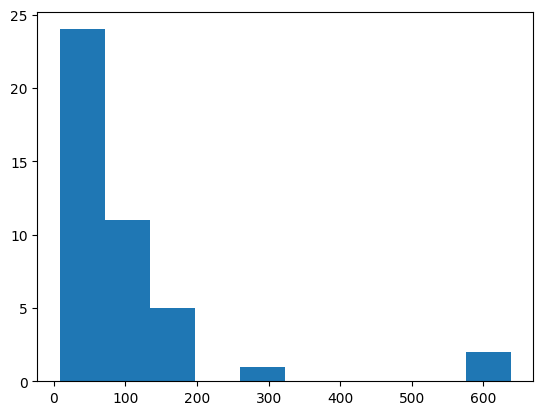

In [33]:
plt.hist(df_regression['euclid_dist'])

In [34]:
df_preds.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0,0
1,29,587,tomo_cabaa0,-1.0,-1.0,-1.0,500,924,956,19.7,0,0
78,403,735,tomo_ff505c,111.0,816.0,678.0,300,959,928,15.6,1,1


In [35]:
tmp = df_preds[(df_preds['Number_of_motors'] == 0) | ((df_preds['Number_of_motors'] == 1) & (df_preds['pred'] == 0))]
tmp.loc[:,'Pred_motor_axis_2'] = -1
tmp.loc[:,'Pred_motor_axis_1'] = -1
tmp.loc[:,'euclid_dist'] = np.nan
tmp.sample(3)

/tmp/ipykernel_18550/1619983113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:,'Pred_motor_axis_2'] = -1
/tmp/ipykernel_18550/1619983113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:,'Pred_motor_axis_1'] = -1
/tmp/ipykernel_18550/1619983113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0,0,-1,-1,NaN
32,151,718,tomo_f8b835,-1.0,-1.0,-1.0,800,928,960,13.1,0,0,-1,-1,NaN
24,124,585,tomo_ca472a,-1.0,-1.0,-1.0,800,928,960,13.1,0,0,-1,-1,NaN


In [36]:
df_full = pd.concat([df_regression, tmp], axis=0)

In [37]:
df_full.shape, df_preds.shape

((115, 15), (115, 12))

In [38]:
df_full

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist
0,292,32,tomo_0a8f05,52.0,587.0,575.0,300,928,928,13.1,1,1,627.693252,461.398773,136.206633
1,303,194,tomo_4102f1,149.0,820.0,485.0,300,928,928,15.6,1,1,565.732689,726.447665,123.571058
2,304,195,tomo_412d88,89.0,103.0,272.0,300,928,928,15.6,1,1,251.851680,106.368482,20.427958
3,305,199,tomo_444829,112.0,786.0,641.0,300,928,928,13.1,1,1,618.322188,805.118541,29.661452
4,323,390,tomo_8c13d9,119.0,442.0,285.0,300,928,928,13.1,1,1,316.404301,410.488889,44.487979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,262,714,tomo_f7f28b,-1.0,-1.0,-1.0,300,960,928,15.6,0,1,-1.000000,-1.000000,NaN
55,289,471,tomo_a67e9f,277.0,158.0,774.0,500,924,956,19.7,1,0,-1.000000,-1.000000,NaN
56,290,694,tomo_ed1c97,241.0,64.0,186.0,500,924,956,19.7,1,0,-1.000000,-1.000000,NaN
62,326,522,tomo_b50c0f,143.0,710.0,779.0,300,928,928,15.6,1,0,-1.000000,-1.000000,NaN


In [39]:
df_processed = df_full.copy()

df_processed['range'] = df_processed['Voxel_spacing'] * df_processed['euclid_dist']

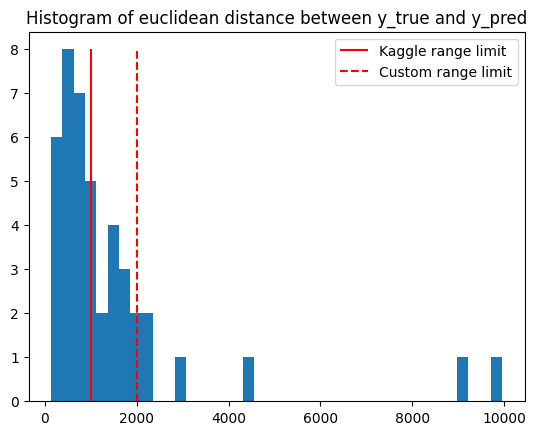

In [40]:
plt.hist(df_processed['range'], bins=40)
plt.vlines(1000, ymin=0, ymax=8, color='r', label='Kaggle range limit')
plt.vlines(2000, ymin=0, ymax=8, color='r', linestyles='dashed', label='Custom range limit')
plt.title('Histogram of euclidean distance between y_true and y_pred')
plt.legend()

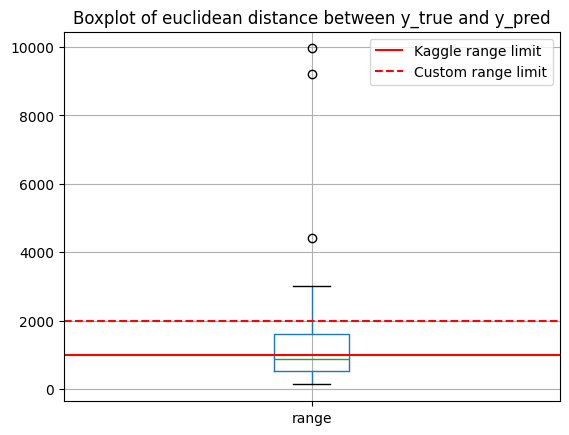

In [41]:
df_processed.boxplot(column='range')
plt.hlines(1000, xmin=0.5, xmax=1.5, color='r', label='Kaggle range limit')
plt.hlines(2000, xmin=0.5, xmax=1.5, color='r', linestyles='dashed', label='Custom range limit')
plt.title('Boxplot of euclidean distance between y_true and y_pred')
plt.legend()

In [42]:
ANGSTROM_RANGE = 2000

t = df_processed.copy()

print(t['pred'].value_counts())

t.loc[t['range'] > ANGSTROM_RANGE, 'pred'] = 0
t.loc[(t['Number_of_motors'] == 1) & (t['pred'] == 1) & (t['Pred_motor_axis_2'] == -1), 'pred'] = 0

print(t['pred'].value_counts())

1    70
0    45
Name: pred, dtype: int64
0    64
1    51
Name: pred, dtype: int64


In [43]:
t[(t['range'] < 2000) & (t['range'] > 1000)].shape, t[(t['range'] < 1000)].shape, t[(t['range'] > 2000)].shape, t[(t['range'].isna())].shape

((13, 16), (24, 16), (6, 16), (72, 16))

In [44]:
t[(t['Pred_motor_axis_1'] == -1) & (t['pred'] == 1)]

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist,range
23,120,564,tomo_c3619a,-1.0,-1.0,-1.0,300,928,928,16.8,0,1,-1.0,-1.0,NaN,NaN
25,131,626,tomo_d6e3c7,-1.0,-1.0,-1.0,300,928,928,16.8,0,1,-1.0,-1.0,NaN,NaN
34,154,729,tomo_fd41c4,-1.0,-1.0,-1.0,300,928,928,16.8,0,1,-1.0,-1.0,NaN,NaN
37,171,79,tomo_1c75ac,-1.0,-1.0,-1.0,300,960,928,15.6,0,1,-1.0,-1.0,NaN,NaN
42,208,359,tomo_7cf523,-1.0,-1.0,-1.0,300,960,928,16.8,0,1,-1.0,-1.0,NaN,NaN
44,213,372,tomo_821255,-1.0,-1.0,-1.0,300,960,928,15.6,0,1,-1.0,-1.0,NaN,NaN
46,234,536,tomo_b9eb9a,-1.0,-1.0,-1.0,300,960,928,15.6,0,1,-1.0,-1.0,NaN,NaN
47,235,543,tomo_bb5ac1,-1.0,-1.0,-1.0,300,960,928,16.8,0,1,-1.0,-1.0,NaN,NaN
48,237,549,tomo_bdc097,-1.0,-1.0,-1.0,300,960,928,16.8,0,1,-1.0,-1.0,NaN,NaN
49,243,579,tomo_c84b46,-1.0,-1.0,-1.0,300,960,928,16.8,0,1,-1.0,-1.0,NaN,NaN


In [45]:
t.shape

(115, 16)

In [46]:
df_full['pred'].value_counts()

1    70
0    45
Name: pred, dtype: int64

In [47]:
df_full['Number_of_motors'].value_counts()

1    60
0    55
Name: Number_of_motors, dtype: int64

In [48]:
df_processed['pred'].value_counts()

1    70
0    45
Name: pred, dtype: int64

In [49]:
t['pred'].value_counts()

0    64
1    51
Name: pred, dtype: int64

In [50]:
fbeta_score(t['Number_of_motors'], t['pred'], beta=2)

0.6357388316151203

In [51]:
print(classification_report(t['Number_of_motors'], t['pred']))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        55
           1       0.73      0.62      0.67        60

    accuracy                           0.68       115
   macro avg       0.68      0.68      0.68       115
weighted avg       0.68      0.68      0.68       115



In [52]:
z_bene = keras.saving.load_model('../models/3d_z.keras', compile=False)

In [53]:
t

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist,range
0,292,32,tomo_0a8f05,52.0,587.0,575.0,300,928,928,13.1,1,1,627.693252,461.398773,136.206633,1784.306897
1,303,194,tomo_4102f1,149.0,820.0,485.0,300,928,928,15.6,1,1,565.732689,726.447665,123.571058,1927.708511
2,304,195,tomo_412d88,89.0,103.0,272.0,300,928,928,15.6,1,1,251.851680,106.368482,20.427958,318.676143
3,305,199,tomo_444829,112.0,786.0,641.0,300,928,928,13.1,1,1,618.322188,805.118541,29.661452,388.565024
4,323,390,tomo_8c13d9,119.0,442.0,285.0,300,928,928,13.1,1,1,316.404301,410.488889,44.487979,582.792521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,262,714,tomo_f7f28b,-1.0,-1.0,-1.0,300,960,928,15.6,0,1,-1.000000,-1.000000,NaN,NaN
55,289,471,tomo_a67e9f,277.0,158.0,774.0,500,924,956,19.7,1,0,-1.000000,-1.000000,NaN,NaN
56,290,694,tomo_ed1c97,241.0,64.0,186.0,500,924,956,19.7,1,0,-1.000000,-1.000000,NaN,NaN
62,326,522,tomo_b50c0f,143.0,710.0,779.0,300,928,928,15.6,1,0,-1.000000,-1.000000,NaN,NaN


In [54]:
t[(t['pred'] == 1) & (t['Pred_motor_axis_2']!=-1)]['Array_shape_axis_0'].unique()

array([300])

In [55]:
test_tomos = ['tomo_dae195', 'tomo_f2fa4a', 'tomo_cabaa0', 'tomo_f7f28b', 'tomo_ed1c97', 'tomo_ff505c', 'tomo_8f4d60', 'tomo_2aeb29', 'tomo_651ecd', 'tomo_e96200', 'tomo_0d4c9e', 'tomo_2dcd5c', 'tomo_983fce', 'tomo_7b1ee3', 'tomo_8b6795', 'tomo_dcb9b4', 'tomo_e764a7', 'tomo_e26c6b', 'tomo_331130', 'tomo_f8b835', 'tomo_746d88', 'tomo_9cd09e', 'tomo_b9eb9a', 'tomo_cf0875', 'tomo_7cf523', 'tomo_fd41c4', 'tomo_54e1a7', 'tomo_ca472a', 'tomo_6478e5', 'tomo_e9b7f2', 'tomo_247826', 'tomo_675583', 'tomo_f0adfc', 'tomo_378f43', 'tomo_19a313', 'tomo_172f08', 'tomo_f3e449', 'tomo_3b83c7', 'tomo_8c13d9', 'tomo_2c607f', 'tomo_c11e12', 'tomo_412d88', 'tomo_4b124b', 'tomo_38c2a6', 'tomo_ec1314', 'tomo_1c38fd', 'tomo_e63ab4', 'tomo_f07244', 'tomo_210371', 'tomo_d6e3c7', 'tomo_935f8a', 'tomo_a4c52f', 'tomo_a46b26', 'tomo_fadbe2', 'tomo_b28579', 'tomo_35ec84', 'tomo_369cce', 'tomo_6c203d', 'tomo_b80310', 'tomo_640a74', 'tomo_22976c', 'tomo_d21396', 'tomo_ecbc12', 'tomo_040b80', 'tomo_85708b', 'tomo_b98cf6', 'tomo_e1e5d3', 'tomo_138018', 'tomo_3264bc', 'tomo_e50f04', 'tomo_d723cd', 'tomo_2a6ca2', 'tomo_1f0e78', 'tomo_67565e', 'tomo_fd5b38', 'tomo_05b39c', 'tomo_372a5c', 'tomo_c3619a', 'tomo_ba76d8', 'tomo_a67e9f', 'tomo_a6646f', 'tomo_db656f', 'tomo_4102f1', 'tomo_bb5ac1', 'tomo_4ed9de', 'tomo_61e947', 'tomo_1da0da', 'tomo_821255', 'tomo_3e7783', 'tomo_c84b46', 'tomo_974fd4', 'tomo_444829', 'tomo_b50c0f', 'tomo_2a6091', 'tomo_fa5d78', 'tomo_bdd3a0', 'tomo_1c2534', 'tomo_d916dc', 'tomo_bdc097', 'tomo_7036ee', 'tomo_cacb75', 'tomo_5b359d', 'tomo_7fa3b1', 'tomo_049310', 'tomo_dd36c9', 'tomo_e3864f', 'tomo_0a8f05', 'tomo_ff7c20', 'tomo_0fab19', 'tomo_1c75ac', 'tomo_d0699e', 'tomo_1e9980', 'tomo_4ee35e', 'tomo_6943e6', 'tomo_99a3ce']

In [56]:
def selection_image_stacks_and_labels(df, num_slices=[300], num_motors=[0,1], xy=False, z=True):
    # Step 1: Filter tomos based on conditions
    df_tomos = df[(df['Array_shape_axis_0'].isin(num_slices)) & (df['Number_of_motors'].isin(num_motors))].copy()
    tomo_ids = df_tomos.tomo_id
    df_select = df[df['tomo_id'].isin(tomo_ids)].copy()

    # Step 2: Build labels
    if xy:
        df_select['motor_coord'] = df_select.apply(lambda row: (row['Motor_axis_2'], row['Motor_axis_1']), axis=1)
    if z:
        df_select['motor_z'] = df_select['Motor_axis_0']

    stack_paths = []
    labels = []

    for _, row in df_select.iterrows():
        tomo_id = row['tomo_id']
        tomo_stack_dir = f'../data/pictures_process/chunks/data_train_process/train_process/tomo_adaptequal_1_chunks/ {tomo_id}'

        if tomo_stack_dir.is_dir():
            # Collect slice files and sort to keep consistent order
            slice_files = sorted(tomo_stack_dir.glob('*.jpg'))
            if len(slice_files) == 30:
                # Append list of full paths (as strings)
                stack_paths.append([str(p) for p in slice_files])
                if xy:
                    labels.append(row['motor_coord'])
                if z:
                    labels.append(row['motor_z'])
            else:
                print(f"⚠️ Tomo {tomo_id} has {len(slice_files)} slices (expected 30). Skipping.")
        else:
            print(f"⚠️ Directory for tomo_id {tomo_id} not found.")

    labels = np.array(labels, dtype=np.float32)
    print(f"✅ Matched {len(stack_paths)} tomo stacks with 30 slices")

    return stack_paths, labels

def read_stack_jpg(image_paths, label, target_size=(240,240)):
    """
    Reads a list of JPEG image paths representing one 3D stack,
    decodes each slice to grayscale, normalizes, and stacks into a 4D tensor.

    Parameters:
    -----------
    image_paths : tf.Tensor (tf.string)
        1D tensor of 30 file paths (strings) for one tomo stack.

    label : tf.Tensor or any
        Label associated with the stack.

    Returns:
    --------
    img_stack : tf.Tensor
        4D tensor of shape (30, height, width, 1) with normalized pixel values.
    label : same as input
        Unchanged label.
    """
    def _read_one_slice(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, target_size)  # resize to fixed size
        img = tf.image.convert_image_dtype(img, tf.float32)  # normalize to [0,1]
        return img

    # Map _read_one_slice over the list of image paths
    img_stack = tf.map_fn(_read_one_slice, image_paths, fn_output_signature=tf.float32)
    return img_stack, label



from pathlib import Path

base_dir = '../data/pictures_process/chunks/data_train_process/train_process/tomo_adaptequal_1_chunks'

base_dir = Path(base_dir)

stack_paths = []
labels = []
tomo_ids = []

df_z_to_find = t[(t['Pred_motor_axis_1']!=-1) & (t['Pred_motor_axis_1']!=-2)]

for _, row in df_z_to_find.iterrows():
    tomo_id = row['tomo_id']
    tomo_stack_dir = base_dir / tomo_id
    tomo_ids.append(tomo_id)

    # Collect slice files and sort to keep consistent order
    slice_files = sorted(tomo_stack_dir.glob('*.jpg'))
    if len(slice_files) == 30:
        # Append list of full paths (as strings)
        stack_paths.append([str(p) for p in slice_files])
        labels.append(row['Motor_axis_0'])

labels = np.array(labels, dtype=np.float32)
print(f"✅ Matched {len(stack_paths)} tomo stacks with 30 slices")


# filtered_tomo_id = list(t.tomo_id)
# test_paths = [f'../data/pictures_process/chunks/data_train_process/train_process/tomo_adaptequal_1_chunks/{tomo_id}.jpg' for tomo_id in filtered_tomo_id]
# test_labels = t.Motor_axis_0
batch_size = 4

✅ Matched 43 tomo stacks with 30 slices


In [57]:
test_ds = tf.data.Dataset.from_tensor_slices((stack_paths, labels)).map(read_stack_jpg).batch(batch_size)

In [58]:
z_bene = keras.saving.load_model('../models/3d_z.keras', compile=False)

In [59]:
z_preds = z_bene.predict(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


In [60]:
pred_dict = {}

for id, pred in zip(tomo_ids, z_preds):
    pred_dict.update({id: pred})

In [61]:
z_col = pd.DataFrame.from_dict(pred_dict, orient='index', columns=['Pred_motor_axis_0']).reset_index()

In [62]:
df_final = pd.merge(t, z_col, left_on='tomo_id', right_on='index', how='outer')
df_final = df_final.drop(columns=['index'])
df_final.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist,range,Pred_motor_axis_0
41,497,355,tomo_7b1ee3,182.0,651.0,626.0,300,960,928,13.1,1,1,589.175947,707.314031,67.285073,881.434454,122.647987
79,120,564,tomo_c3619a,-1.0,-1.0,-1.0,300,928,928,16.8,0,1,-1.000000,-1.000000,NaN,NaN,NaN
102,234,536,tomo_b9eb9a,-1.0,-1.0,-1.0,300,960,928,15.6,0,1,-1.000000,-1.000000,NaN,NaN,NaN


In [63]:
df_final = df_final.rename({
    'euclid_dist': 'euclid_dist_2D',
    'range': 'range_2D',
}, axis=1)

In [64]:
df_final.sample()

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,pred,Pred_motor_axis_2,Pred_motor_axis_1,euclid_dist_2D,range_2D,Pred_motor_axis_0
33,447,189,tomo_3e7783,186.0,531.0,617.0,300,960,928,13.1,1,1,607.917717,490.022561,41.971876,549.831569,149.070282


In [65]:
df_final['euclid_dist_3D'] = tf.sqrt((df_final['Motor_axis_2'] - df_final['Pred_motor_axis_2'])**2 + (df_final['Motor_axis_1'] - df_final['Pred_motor_axis_1'])**2 + (df_final['Motor_axis_0'] - df_final['Pred_motor_axis_0'])**2)

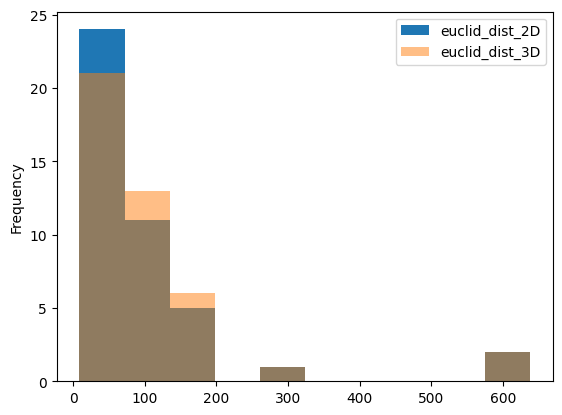

In [66]:
df_final['euclid_dist_2D'].plot(kind='hist', label='euclid_dist_2D')
df_final['euclid_dist_3D'].plot(kind='hist', label='euclid_dist_3D', alpha=0.5)
plt.legend()

In [67]:
df_final['range_3D'] = df_final['Voxel_spacing'] * df_final['euclid_dist_3D']

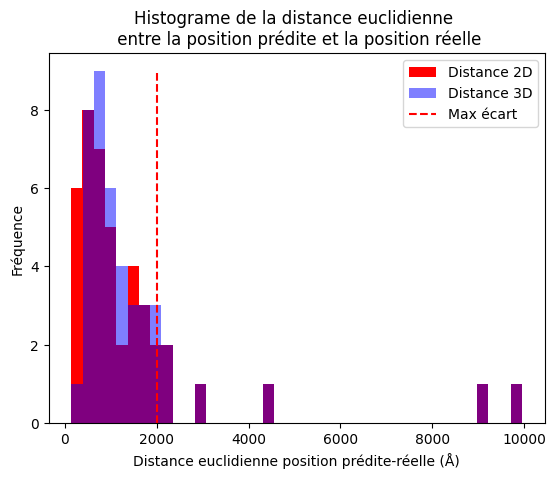

In [82]:
df_final['range_2D'].plot(kind='hist', label='Distance 2D', bins=40, color='red')
df_final['range_3D'].plot(kind='hist', label='Distance 3D', alpha=0.5, bins=40, color='b')
plt.vlines(2000, ymin=0, ymax=9, color='r', linestyles='dashed', label='Max écart')
plt.title('Histograme de la distance euclidienne \n entre la position prédite et la position réelle')
plt.xlabel("Distance euclidienne position prédite-réelle (Å)")
plt.ylabel('Fréquence')
plt.legend()

In [69]:
df_final.shape

(115, 19)

In [70]:
ANGSTROM_RANGE = 2000

df_sanctionned_3D = df_final.copy()

df_sanctionned_3D.loc[(df_sanctionned_3D['range_3D'] > ANGSTROM_RANGE) & (df_sanctionned_3D['pred'] ==1), 'pred'] = 0

In [71]:
fbeta_score(df_sanctionned_3D['Number_of_motors'], df_sanctionned_3D['pred'], beta=2)

0.6206896551724137

In [72]:
print(classification_report(df_sanctionned_3D['Number_of_motors'], df_sanctionned_3D['pred']))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68        55
           1       0.72      0.60      0.65        60

    accuracy                           0.67       115
   macro avg       0.68      0.67      0.67       115
weighted avg       0.68      0.67      0.67       115



([], [])

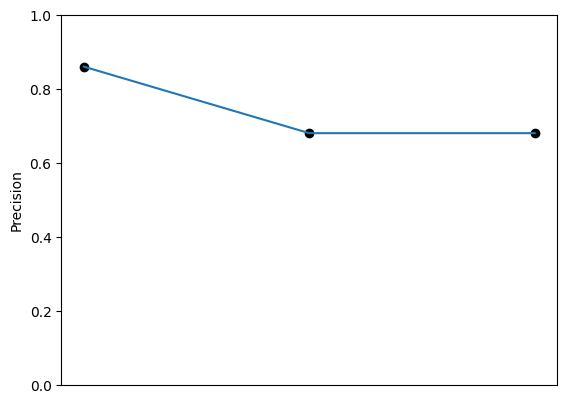

In [80]:
scores = [0.86, 0.68, 0.68]
x = [0, 1, 2]
plt.plot(scores)
plt.scatter(x, scores, c='black')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.xticks([])

Text(0.5, 0, 'Distance euclidienne (Å)')

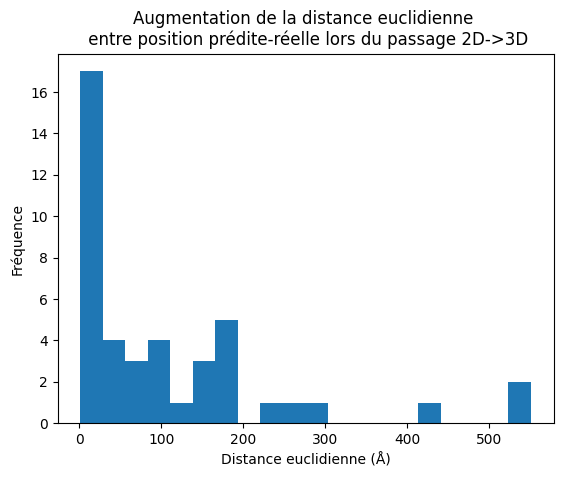

In [81]:
plt.hist(df_final['range_3D']-df_final['range_2D'], bins=20)
plt.title('Augmentation de la distance euclidienne \n entre position prédite-réelle lors du passage 2D->3D')
plt.ylabel('Fréquence')
plt.xlabel('Distance euclidienne (Å)')

In [75]:
test_benedetta = ['tomo_6f0ee4',
 'tomo_a537dd',
 'tomo_30d4e5',
 'tomo_d21396',
 'tomo_8e8368',
 'tomo_71ece1',
 'tomo_9f222a',
 'tomo_6733fa',
 'tomo_57592d',
 'tomo_adc026',
 'tomo_d916dc',
 'tomo_d6c63f',
 'tomo_24795a',
 'tomo_03437b',
 'tomo_378f43',
 'tomo_d83ff4',
 'tomo_210371',
 'tomo_0fab19',
 'tomo_e1e5d3',
 'tomo_8f063a',
 'tomo_99a3ce',
 'tomo_fc3c39',
 'tomo_9cd09e',
 'tomo_e5ac94',
 'tomo_d2b1bc',
 'tomo_672101',
 'tomo_05df8a',
 'tomo_3c6038',
 'tomo_7fbc49',
 'tomo_d3bef7',
 'tomo_417e5f',
 'tomo_b54396',
 'tomo_0eb994',
 'tomo_c00ab5',
 'tomo_3e7783',
 'tomo_53e048',
 'tomo_94c173',
 'tomo_89d156',
 'tomo_dfc627',
 'tomo_412d88',
 'tomo_101279',
 'tomo_cd1a7c',
 'tomo_95e699',
 'tomo_4f379f',
 'tomo_a1a9a3',
 'tomo_0da370',
 'tomo_16136a',
 'tomo_32aaa7',
 'tomo_d23087',
 'tomo_acadd7',
 'tomo_6bc974',
 'tomo_98d455',
 'tomo_317656',
 'tomo_d0aa3b',
 'tomo_e57baf',
 'tomo_1efc28',
 'tomo_d7475d',
 'tomo_68e123',
 'tomo_375513',
 'tomo_9d3a0e',
 'tomo_e2ccab']

In [76]:
test_tomos

['tomo_dae195',
 'tomo_f2fa4a',
 'tomo_cabaa0',
 'tomo_f7f28b',
 'tomo_ed1c97',
 'tomo_ff505c',
 'tomo_8f4d60',
 'tomo_2aeb29',
 'tomo_651ecd',
 'tomo_e96200',
 'tomo_0d4c9e',
 'tomo_2dcd5c',
 'tomo_983fce',
 'tomo_7b1ee3',
 'tomo_8b6795',
 'tomo_dcb9b4',
 'tomo_e764a7',
 'tomo_e26c6b',
 'tomo_331130',
 'tomo_f8b835',
 'tomo_746d88',
 'tomo_9cd09e',
 'tomo_b9eb9a',
 'tomo_cf0875',
 'tomo_7cf523',
 'tomo_fd41c4',
 'tomo_54e1a7',
 'tomo_ca472a',
 'tomo_6478e5',
 'tomo_e9b7f2',
 'tomo_247826',
 'tomo_675583',
 'tomo_f0adfc',
 'tomo_378f43',
 'tomo_19a313',
 'tomo_172f08',
 'tomo_f3e449',
 'tomo_3b83c7',
 'tomo_8c13d9',
 'tomo_2c607f',
 'tomo_c11e12',
 'tomo_412d88',
 'tomo_4b124b',
 'tomo_38c2a6',
 'tomo_ec1314',
 'tomo_1c38fd',
 'tomo_e63ab4',
 'tomo_f07244',
 'tomo_210371',
 'tomo_d6e3c7',
 'tomo_935f8a',
 'tomo_a4c52f',
 'tomo_a46b26',
 'tomo_fadbe2',
 'tomo_b28579',
 'tomo_35ec84',
 'tomo_369cce',
 'tomo_6c203d',
 'tomo_b80310',
 'tomo_640a74',
 'tomo_22976c',
 'tomo_d21396',
 'tomo_e

In [77]:
res = list(set(test_tomos) & set(test_benedetta))

In [78]:
res

['tomo_99a3ce',
 'tomo_210371',
 'tomo_0fab19',
 'tomo_3e7783',
 'tomo_412d88',
 'tomo_e1e5d3',
 'tomo_378f43',
 'tomo_9cd09e',
 'tomo_d916dc',
 'tomo_d21396']

In [79]:
len(res), len(res)/len(test_tomos)

(10, 0.08695652173913043)